In [1]:
import os
import numpy as np
import seaborn as sns; 
import matplotlib.pyplot as plt

from numpy import dot
from numpy.linalg import norm
from konlpy.tag import Okt
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

## 프로젝트: 모든 장르 간 편향성 측정해 보기

### 1. 전체 synopsis 파일을 이용해서 Word2Vec 임베딩 모델 만들기

In [2]:
# 전체 Synopsis 파일을 이용해서 Word2Vec 임베딩 모델 만들기
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line:
            break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun", "Adjective", "Verb"] and len(w[0]) > 1: # 명사, 동사, 형용사이면서, 글자 수가 2 이상
                res.append(w[0])
        tokenized.append(res)

print(f'전체 문장 수: {len(tokenized)}')

전체 문장 수: 71156


In [3]:
# tokenized에 담긴 데이터를 가지고 Word2Vec을 생성 (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)

In [4]:
# 결과 테스트
print(model.wv.most_similar(positive=['영화']))
print(model.wv.most_similar(positive=['사랑']))
print(model.wv.most_similar(positive=['모험']))

[('작품', 0.8550687432289124), ('다큐멘터리', 0.8290387988090515), ('드라마', 0.8253006339073181), ('영화로', 0.819814920425415), ('편의', 0.8041735291481018), ('코미디', 0.7868514657020569), ('형식', 0.7780638337135315), ('바탕', 0.7602933645248413), ('주제', 0.7589792609214783), ('실화', 0.7562182545661926)]
[('상심', 0.7057009339332581), ('락앤롤', 0.676616370677948), ('딜레마', 0.6732988357543945), ('첫사랑', 0.6670613288879395), ('행복', 0.6568850874900818), ('달콤하다', 0.647021472454071), ('실의', 0.6437138319015503), ('우정', 0.6428673267364502), ('슬럼프', 0.6385372877120972), ('자괴', 0.6382330656051636)]
[('여정', 0.8835805058479309), ('탐험', 0.8164990544319153), ('험난하다', 0.7595699429512024), ('시간여행', 0.7480765581130981), ('여행', 0.7331966161727905), ('사냥', 0.7225440740585327), ('어드벤처', 0.7147165536880493), ('머나멀다', 0.7145113945007324), ('일주', 0.7101855874061584), ('브레히트', 0.6943657398223877)]


#### 분석
- 형태소 분석기를 이용한 토큰화에서 명사, 동사, 형용사인 단어를 추가
- most_similar() 함수를 이용한 유사 단어 출력에서 대체로 유사한 단어가 나타나는 것으로 확인됨
- 주제어와 거리가 멀다고 생각되는 예시들: '영화'-'편의', '사랑'-'락앤롤', '모험'-'브레히트'(독일의 극작가)

### 2. WEAT Score 함수

In [5]:
# 두 벡터의 코사인 유사도
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))

In [6]:
# 딘어 w의 편향성 - Target Set에 있는 단어 w가, Attribute Set A, B에 있는 단어들과의 유사도의 평균의 차이
def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B

In [7]:
# WEAT Score
def weat_score(X, Y, A, B):
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    return  (mean_X-mean_Y)/std_dev

### 3. Target Set 만들기

In [8]:
def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun", "Adjective", "Verb"] and len(word[0]) > 1: # 명사, 동사, 형용사이면서, 글자 수가 2 이상
                    result.append((word[0])) 
    return ' '.join(result)

In [9]:
# 예술 영화/상업 영화 텍스트 읽어서 토큰화
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


In [10]:
vectorizer = TfidfVectorizer()
tfidf_artgen = vectorizer.fit_transform([art, gen])

In [11]:
m1 = tfidf_artgen[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = tfidf_artgen[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술 영화를 대표하는 단어들 (중복 제거 전):')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w1[i][0]], end=', ')

print('\n')
    
print('일반 영화를 대표하는 단어들 (중복 제거 전):')
for i in range(100):
    print(vectorizer.get_feature_names_out()[w2[i][0]], end=', ')

예술 영화를 대표하는 단어들 (중복 제거 전):
하다, 되다, 있다, 그녀, 자신, 시작, 없다, 위해, 사랑, 않다, 사람, 늘다, 받다, 오다, 영화, 친구, 가다, 만나다, 남자, 찾다, 이다, 그렇다, 떠나다, 가족, 같다, 이야기, 되어다, 마을, 보다, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 빠지다, 여자, 버리다, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 보내다, 느끼다, 새롭다, 아내, 살다, 다른, 싶다, 모르다, 사이, 영화제, 세계, 사실, 크다, 하나, 들다, 만들다, 잃다, 점점, 남편, 감독, 어리다, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 찾아오다, 마지막, 생활, 아빠, 죽다, 지키다, 모습, 통해, 아니다, 죽음, 기억, 비밀, 학교, 말다, 음악, 아름답다, 한편, 당하다, 소년, 살아가다, 생각, 도시, 명의, 인하다, 나타나다, 사고, 

일반 영화를 대표하는 단어들 (중복 제거 전):
하다, 되다, 있다, 자신, 그녀, 영화제, 없다, 위해, 않다, 사람, 시작, 국제, 영화, 받다, 친구, 사랑, 남자, 오다, 이다, 늘다, 가다, 이야기, 되어다, 보다, 그렇다, 만나다, 찾다, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 같다, 떠나다, 버리다, 다른, 들다, 마을, 아니다, 시간, 엄마, 아들, 모든, 만들다, 단편, 마음, 살다, 사실, 다시, 보내다, 세계, 모습, 빠지다, 작품, 통해, 생각, 서로, 싶다, 느끼다, 세상, 발견, 감독, 새롭다, 아내, 관계, 소녀, 사이, 시키다, 어리다, 하나, 크다, 우리, 애니메이션, 때문, 어떻다, 모르다, 죽다, 여성, 당하다, 주다, 말다, 죽음, 과연, 점점, 인간, 생활, 한편, 잃다, 결혼, 상황, 모두, 내다, 기억, 이르다, 나타나다, 명의, 소년, 

#### 디버깅
- get_feature_names() 함수가 더 이상 지원되지 않는다는 경고 메시지 발생하여 get_feature_names_out() 함수로 변경
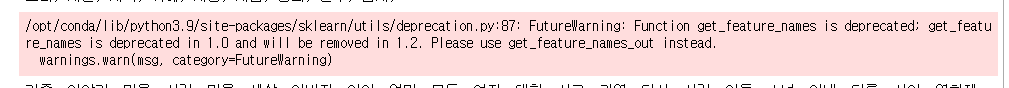

In [13]:
# 서로 독립적인 단어들을 추출
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names_out()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names_out()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv):
        target_art.append(w1_[i])
    if len(target_art) == n:
        break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv):
        target_gen.append(w2_[i])
    if len(target_gen) == n:
        break

print('예술 영화를 대표하는 단어들 (중복 제거 후):', target_art)
print('일반 영화를 대표하는 단어들 (중복 제거 후):', target_gen)

예술 영화를 대표하는 단어들 (중복 제거 후): ['여행', '인생', '순간', '가장', '찾아오다', '마지막', '아빠', '지키다', '비밀', '학교', '음악', '아름답다', '살아가다', '도시', '인하다']
일반 영화를 대표하는 단어들 (중복 제거 후): ['국제', '서울', '단편', '작품', '관계', '시키다', '애니메이션', '때문', '어떻다', '여성', '주다', '인간', '결혼', '상황', '내다']


#### 분석
- 토큰화 단계에서 명사, 동사, 형용사인 단어들이 포함되었음.
- 중복 제거 전 단어 목록에서 예술 영화와 일반 영화에 모두 포함된 단어는 모두 제거되었음을 확인
- 예술 영화를 대표하는 단어들은 '여행', '인생', '마지막' 등 납득할 만한 단어들이 선택된 것으로 보임
- 상대적으로 일반 영화를 대표하는 단어들인 '서울', '단편' 등 납득하기 어려운 단어들이 다수 포함된 것으로 보임

### 4. Attribute Set 만들기

In [14]:
# 데이터 셋 준비
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [15]:
# 장르별 텍스트를 읽어서 토큰화
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [16]:
# TF-IDF 구하기
vectorizer = TfidfVectorizer()
tfidf_genre = vectorizer.fit_transform(genre)

In [17]:
# TF-IDF 값을 기준으로 대표 단어 추출
m = [tfidf_genre[i].tocoo() for i in range(tfidf_genre.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

attributes = []
for i in range(len(w)):
    print(f'{genre_name[i]} 영화를 대표하는 단어들', end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names_out()[w[i][j][0]])
            print(vectorizer.get_feature_names_out()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF 영화를 대표하는 단어들: 하다, 되다, 있다, 위해, 자신, 지구, 시작, 사람, 인류, 없다, 인간, 않다, 늘다, 미래, 받다, 
가족 영화를 대표하는 단어들: 하다, 되다, 있다, 엄마, 아빠, 가족, 영화제, 자신, 위해, 없다, 오다, 않다, 친구, 아주르, 아버지, 
공연 영화를 대표하는 단어들: 하다, 되다, 오페라, 사랑, 있다, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 
공포(호러) 영화를 대표하는 단어들: 하다, 되다, 있다, 없다, 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 않다, 공포, 받다, 발견, 
기타 영화를 대표하는 단어들: 하다, 영화제, 되다, 국제, 있다, 서울, 단편, 영화, 자신, 사람, 이야기, 않다, 그녀, 없다, 남자, 
다큐멘터리 영화를 대표하는 단어들: 하다, 있다, 되다, 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 않다, 대한, 자신, 감독, 없다, 
드라마 영화를 대표하는 단어들: 하다, 되다, 있다, 자신, 영화제, 그녀, 없다, 않다, 사람, 사랑, 영화, 위해, 시작, 받다, 국제, 
멜로로맨스 영화를 대표하는 단어들: 하다, 되다, 그녀, 있다, 사랑, 자신, 시작, 남편, 없다, 남자, 여자, 사람, 않다, 친구, 섹스, 
뮤지컬 영화를 대표하는 단어들: 하다, 되다, 있다, 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 
미스터리 영화를 대표하는 단어들: 하다, 되다, 있다, 사건, 그녀, 없다, 시작, 자신, 위해, 받다, 않다, 사람, 발견, 사고, 진실, 
범죄 영화를 대표하는 단어들: 하다, 되다, 있다, 사건, 위해, 자신, 경찰, 시작, 없다, 늘다, 그녀, 않다, 받다, 범죄, 조직, 
사극 영화를 대표하는 단어들: 하다, 되다, 조선, 있다, 위해, 시작, 없다, 신기전, 사랑, 늘다, 자신, 아가멤논, 황제, 않다, 그녀, 
서부극(웨스턴) 영화를 대표하는 단어들: 

#### 분석
- 영화별로 비슷한 단어들이 중복되어 많이 나타남
- 중복되는 단어를 제거하는 기능 필요

In [33]:
# 단어 목록 얻어오기
w_ = []
for i in range(len(w)):
    feature_name = []
    for j in range(600):
        feature_name.append(vectorizer.get_feature_names()[w[i][j][0]])
    w_.append(feature_name)

In [34]:
# 단어가 다른 장르에 포함되는지 여부를 찾는 함수
def isExist(word, pos):
    is_exist = True
    for i in range(len(w)):
        if not i == pos and word in w_[i]:
            is_exist = False
    return is_exist
# print(isExist('하다', 0))

In [35]:
# 중복 단어 제거
attributes = []
for i in range(len(w)):
    print(f'{genre_name[i]} 영화를 대표하는 단어들 (중복 제거)', end=': ')
    attr = []
    j = 0
    while (len(attr) < 8):
        if (isExist(w_[i][j], i) == True) and (w_[i][j] in model.wv):
            attr.append(w_[i][j])
            print(w_[i][j], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF 영화를 대표하는 단어들 (중복 제거): 스타크, 리플리, 켈빈, 컨트, 수퍼맨, 분파, 물체, 진화, 
가족 영화를 대표하는 단어들 (중복 제거): 아주르, 낙타, 씨제이, 동구, 슈이트, 마갈, 미아, 펠리칸, 
공연 영화를 대표하는 단어들 (중복 제거): 실황, 올레, 오텔로, 리골레토, 프레, 베르디, 비바, 콘서트, 
공포(호러) 영화를 대표하는 단어들 (중복 제거): 악령, 섬뜩하다, 분홍신, 캠핑, 정신병원, 레드, 에이미, 심령, 
기타 영화를 대표하는 단어들 (중복 제거): 뉴미디어, 메트로, 실험영화, 프라이드, 공사, 독도, 재연, 교통, 
다큐멘터리 영화를 대표하는 단어들 (중복 제거): 투쟁, 인디다큐페스티발, 지난, 건축사, 세대, 공동체, 세월호, 산업, 
드라마 영화를 대표하는 단어들 (중복 제거): 하루하루, 청춘, 데뷔, 교사, 장례식, 불편하다, 힘드다, 어울리다, 
멜로로맨스 영화를 대표하는 단어들 (중복 제거): 미연, 펜션, 수진, 하숙집, 주희, 준석, 처제, 호감, 
뮤지컬 영화를 대표하는 단어들 (중복 제거): 에스메랄다, 충무로, 니웨, 바흐, 페뷔스, 프롤, 모도, 제루샤, 
미스터리 영화를 대표하는 단어들 (중복 제거): 방독면, 랭던, 몰카, 거미숲, 홈즈, 종섭, 한나, 승호, 
범죄 영화를 대표하는 단어들 (중복 제거): 한길수, 파푸아, 금고, 마샨, 철중, 도미, 사기꾼, 맥베드, 
사극 영화를 대표하는 단어들 (중복 제거): 신기전, 아가멤논, 루안, 하선, 윤서, 세자, 허균, 노준, 
서부극(웨스턴) 영화를 대표하는 단어들 (중복 제거): 벌린, 카우보이, 그레이프바인, 개릿, 무법자, 프린트, 마적, 태구, 
성인물(에로) 영화를 대표하는 단어들 (중복 제거): 유이, 욕구불만, 성관계, 흥분하다, 카즈야, 애무, 타케시, 타츠야, 
스릴러 영화를 대표하는 단어들 (중복 제거): 영훈, 감금, 혜영, 트래셔, 탤리, 명훈, 이하연, 성열, 
애니메이션 영화를 대표하는 단어들 (중복 제거): 

#### 디버깅
- 단어 중복을 제거하면 드라마에서 최대 8개의 단어밖에 추출되지 않음
- 추출된 단어들의 TF-IDF 지수가 낮을 것으로 예상되지만, 추출된 단어는 상대적으로 각 장르 영화를 대표하는 단어로 생각됨

### 5. WEAT Score 구하기

In [36]:
# WEAT Score 구하기
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [37]:
# 결과값 출력
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        print(genre_name[i], genre_name[j],matrix[i][j])

SF 가족 -0.71722233
SF 공연 0.15322956
SF 공포(호러) -0.90955716
SF 기타 0.6569226
SF 다큐멘터리 0.37684593
SF 드라마 -0.3998044
SF 멜로로맨스 -0.34643027
SF 뮤지컬 0.38685066
SF 미스터리 -0.5133274
SF 범죄 -0.21047364
SF 사극 0.28879678
SF 서부극(웨스턴) -0.4992095
SF 성인물(에로) -0.068853825
SF 스릴러 -0.32679313
SF 애니메이션 -0.5385075
SF 액션 -0.4588362
SF 어드벤처 -0.5920505
SF 전쟁 -0.39967024
SF 코미디 -0.4493039
SF 판타지 -0.66616625
가족 공연 0.8387035
가족 공포(호러) 0.05900832
가족 기타 1.0309002
가족 다큐멘터리 0.713512
가족 드라마 0.59847134
가족 멜로로맨스 0.31310058
가족 뮤지컬 1.02812
가족 미스터리 0.7098163
가족 범죄 0.8346973
가족 사극 1.22874
가족 서부극(웨스턴) 0.7351897
가족 성인물(에로) 0.5889091
가족 스릴러 0.7199595
가족 애니메이션 0.5319425
가족 액션 0.5809062
가족 어드벤처 0.68647367
가족 전쟁 0.5404957
가족 코미디 0.99944305
가족 판타지 0.3093018
공연 공포(호러) -0.73872894
공연 기타 0.7612644
공연 다큐멘터리 0.18707727
공연 드라마 -0.53309536
공연 멜로로맨스 -0.4334908
공연 뮤지컬 0.5645112
공연 미스터리 -0.5207243
공연 범죄 -0.28122506
공연 사극 0.060486436
공연 서부극(웨스턴) -0.5527315
공연 성인물(에로) -0.13498984
공연 스릴러 -0.36680856
공연 애니메이션 -0.75944805
공연 액션 -0.44906467
공연 어드벤처 -

### 6. 시각화

<AxesSubplot:>

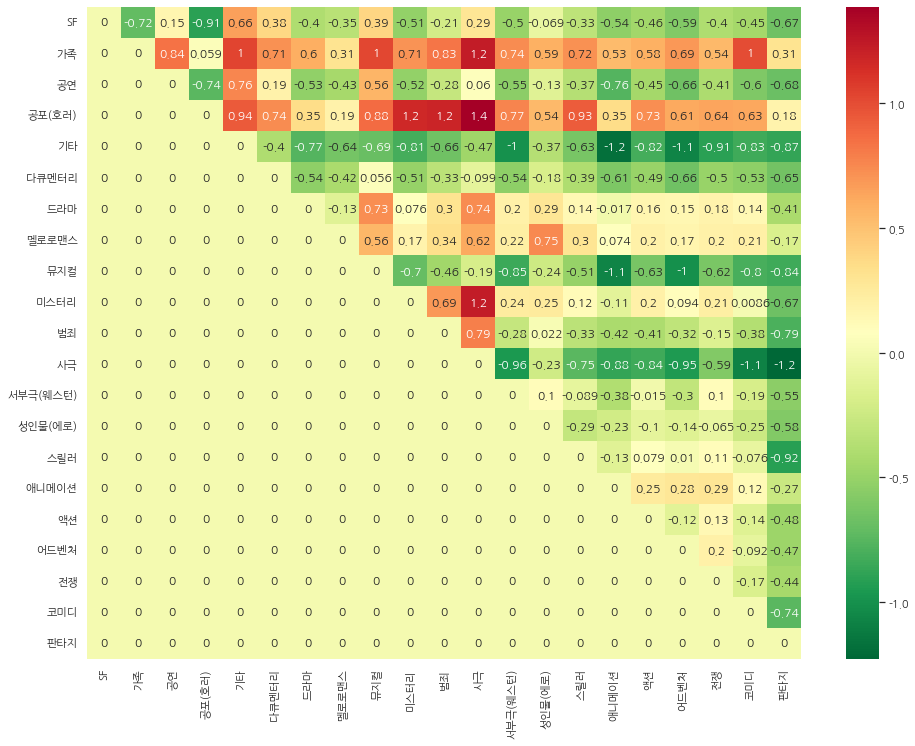

In [38]:
sns.set(font='NanumGothic')

plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (16,12)

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True, cmap='RdYlGn_r')
ax

### 분석
- 문장에서 명사만 추출하고, 장르 별 중복 단어를 제거하지 않았을 때의 WEAT 스코어 heat map
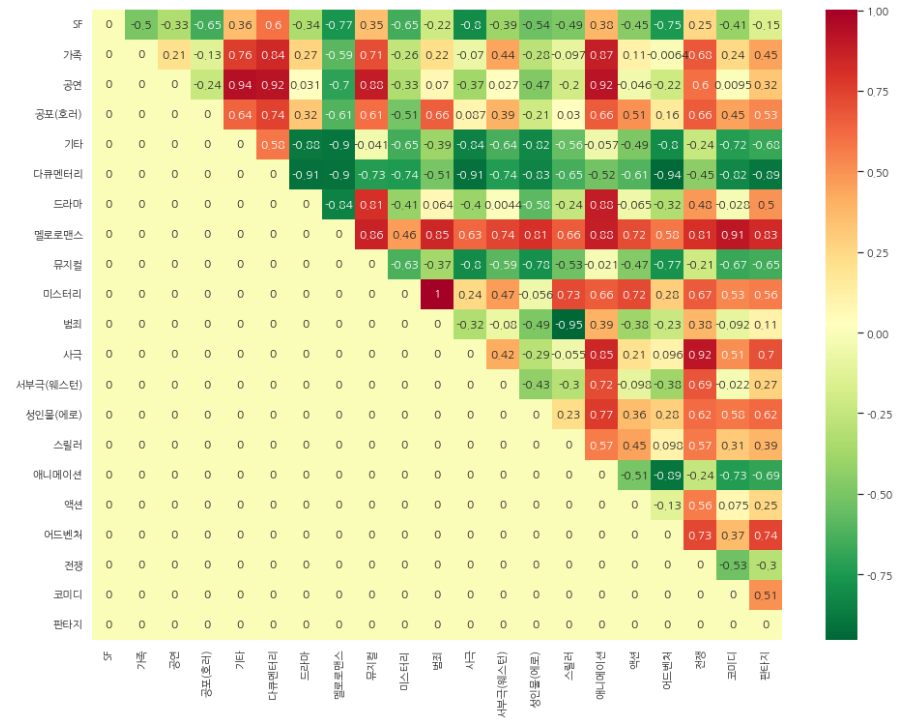

## 회고
- Okt를 이용한 문장의 형태소 분석에 상당한 시간이 걸림. 빠른 형태소 분석기의 필요성 확인
- 텍스트 파일을 확인했을 때, 하나의 synopsis가 여러 줄에 걸쳐서 작성되어 있으나, 형태소 분석기는 라인 별로 처리하도록 구성하고 있음 (정확한 형태소 분석이 어려울 수 있음)
- 문장에서 명사만 추출하고, 중복 단어 제거를 하지 않았을 때의 WEAT 스코어와 문장에서 명사, 동사, 형용사를 추출하고 중복 단어를 제거했을 때의 WEAT 스코어가 상당한 차이가 있음.